## Transfer Learning mobilenetV2 using Tensorflow

In [2]:
!nvidia-smi

Wed Nov  9 04:46:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 526.47       Driver Version: 526.47       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A    0C    P8    N/A /  N/A |      0MiB /  2048MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:

import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
# from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [3]:
# re-size all the images to this
IMAGE_SIZE = (224, 224)

train_path = r'D:\image classification\done\random model\train'
valid_path = r'D:\image classification\done\random model\val'
test_path = r'D:\image classification\done\random model\test'

In [4]:
  # useful for getting number of output classes
folders = glob(r'D:\image classification\done\random model\train\*')
folders

['D:\\image classification\\done\\random model\\train\\medical',
 'D:\\image classification\\done\\random model\\train\\random']

In [6]:
import os
random_train = len(os.listdir(folders[1]))
medical_train = len(os.listdir(folders[0]))
print(f"No of Random files {random_train}\nNo of Medical files {medical_train}\n")

No of Random files 2943
No of Medical files 3214



In [20]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# train_datagen = ImageDataGenerator(rescale = 1./255,
#                                    shear_range = 0.2,
#                                    zoom_range = 0.2,
#                                    horizontal_flip = True)

train_datagen = ImageDataGenerator(rotation_range=15,
                                    rescale=1./255,
                                    shear_range=0.1,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1)
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 16,
                                                 class_mode = 'binary',
                                                 color_mode="rgb")

Found 6139 images belonging to 2 classes.


In [21]:
test_datagen = ImageDataGenerator(rescale = 1./255)
val_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 16,
                                            class_mode = 'binary',
                                            shuffle = True,
                                            color_mode="rgb")

Found 1689 images belonging to 2 classes.


In [22]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 16,
                                            class_mode = 'binary',
                                            shuffle = False,
                                            color_mode="rgb")

Found 840 images belonging to 2 classes.


### Model

In [23]:
engine = tf.keras.applications.MobileNetV2(
        # Freezing the weights of the top layer in the InceptionResNetV2 pre-traiined model
        include_top = False,
        # Use Imagenet weights
        weights = 'imagenet',
        # Define input shape to 224x224x3
        input_shape = (224 , 224 , 3),
    )

In [24]:
x = tf.keras.layers.GlobalAveragePooling2D(name = 'avg_pool')(engine.output)
x = tf.keras.layers.Dropout(0.75)(x)
x = tf.keras.layers.BatchNormalization(
                      axis=-1,
                      momentum=0.99,
                      epsilon=0.01,
                      center=True,
                      scale=True,
                      beta_initializer="zeros",
                      gamma_initializer="ones",
                      moving_mean_initializer="zeros",
                      moving_variance_initializer="ones",
                  )(x)
prediction = Dense(1, activation = 'sigmoid', name = 'dense_output')(x)
 # Build the Keras model
model = Model(inputs = engine.input, outputs = prediction)

In [25]:
# tell the model what cost and optimization method to use
model.compile(
  loss='binary_crossentropy',
  # optimizer='adam',
  optimizer= Adam(learning_rate=0.001),
  metrics=['accuracy']
)

In [26]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [27]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                            patience=2,
                                                            verbose=2,
                                                            factor=0.5,
                                                            min_lr=0.00001)
reduce_lr =  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.00001)

In [29]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit(
  training_set,
  validation_data=val_set,
  epochs=20,
  batch_size = 16,
  callbacks=[early_stopping, reduce_lr , learning_rate_reduction]
)

Epoch 1/20
384/384 [==============================] - 410s 1s/step - loss: 0.0455 - accuracy: 0.9865 - val_loss: 0.1506 - val_accuracy: 0.9793 - lr: 0.0010
Epoch 2/20
384/384 [==============================] - 410s 1s/step - loss: 0.0732 - accuracy: 0.9769 - val_loss: 0.2214 - val_accuracy: 0.9811 - lr: 0.0010
Epoch 3/20
384/384 [==============================] - 411s 1s/step - loss: 0.0322 - accuracy: 0.9923 - val_loss: 4.2199 - val_accuracy: 0.8040 - lr: 0.0010
Epoch 4/20
384/384 [==============================] - ETA: 0s - loss: 0.0288 - accuracy: 0.9917
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
384/384 [==============================] - 411s 1s/step - loss: 0.0288 - accuracy: 0.9917 - val_loss: 0.2547 - val_accuracy: 0.9633 - lr: 5.0000e-04
Epoch 5/20
384/384 [==============================] - 411s 1s/step - loss: 0.0163 - accuracy: 0.9954 - val_loss: 0.0898 - val_accuracy: 0.9882 - lr: 2.5000e-04
Epoch 6/20
384/384 [==============================]

In [30]:
import matplotlib.pyplot as plt

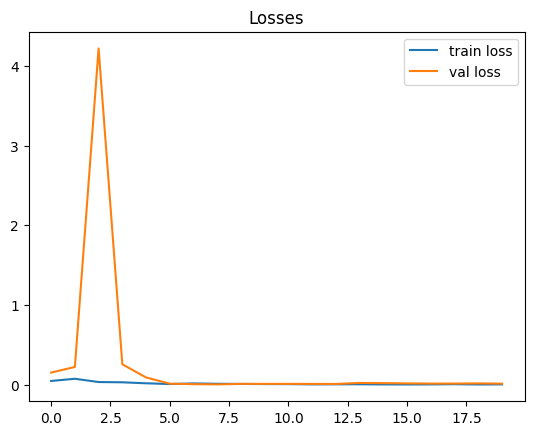

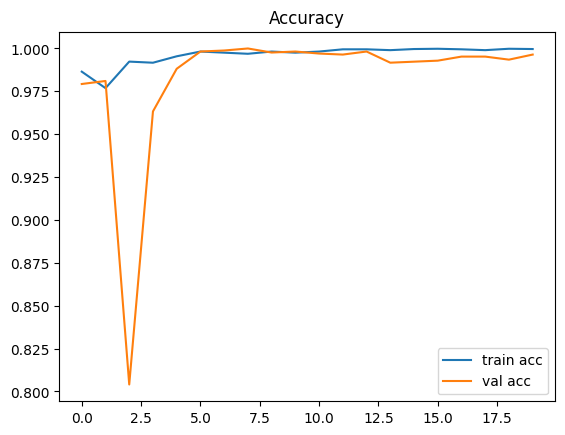

<Figure size 640x480 with 0 Axes>

In [31]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses')
plt.show()
plt.savefig('LossVal_loss')
print()
# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')
plt.show()
plt.savefig('AccVal_acc')

In [32]:
# average training accuracy
np.mean(r.history['accuracy'])

0.9962534606456757

In [33]:
# val accuracy
model.evaluate(val_set)

106/106 [==============================] - 33s 310ms/step - loss: 0.0117 - accuracy: 0.9964


[0.011716247536242008, 0.9964476227760315]

In [34]:
# test accuracy
model.evaluate(test_set)

53/53 [==============================] - 19s 353ms/step - loss: 0.0193 - accuracy: 0.9929


[0.019294755533337593, 0.9928571581840515]

In [35]:
test_set.class_indices

{'medical': 0, 'random': 1}

In [36]:
test_set.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [37]:
from sklearn.metrics import confusion_matrix, classification_report
prob = model.predict(test_set)
print(prob)

53/53 [==============================] - 17s 305ms/step
[[5.33389742e-04]
 [1.70177687e-02]
 [1.59851951e-03]
 [7.48083368e-02]
 [4.26266715e-02]
 [1.16409974e-05]
 [2.27761623e-02]
 [3.26063528e-05]
 [2.23526324e-04]
 [4.26470011e-04]
 [8.37354176e-03]
 [5.35535812e-03]
 [1.80067271e-02]
 [1.47848832e-03]
 [3.27764754e-03]
 [3.94819044e-02]
 [2.88342703e-02]
 [1.92092732e-02]
 [1.78597253e-02]
 [9.90580842e-02]
 [7.01541603e-01]
 [1.88323528e-01]
 [1.27915544e-02]
 [4.85480792e-04]
 [1.54956906e-05]
 [9.05121735e-04]
 [1.29272824e-03]
 [1.09545981e-04]
 [2.61526700e-04]
 [4.22691042e-03]
 [7.07634315e-02]
 [9.05449095e-04]
 [1.73908956e-02]
 [2.57516134e-04]
 [6.36182434e-04]
 [8.94115567e-02]
 [5.12264716e-03]
 [5.48312619e-06]
 [3.32582905e-03]
 [4.17258544e-03]
 [7.98157766e-04]
 [1.11640652e-03]
 [2.28961650e-02]
 [1.04016420e-02]
 [2.41389475e-03]
 [5.13719686e-04]
 [1.74684241e-01]
 [2.43627699e-03]
 [7.42723569e-02]
 [1.30516011e-02]
 [8.42958130e-03]
 [4.14515707e-05]
 [7.8771

In [38]:
from sklearn.metrics import confusion_matrix, classification_report
prob = model.predict(test_set)
result = []
for i in range(0,len(prob)):
  if prob[i]>0.5:
    result.append(1)
  else:
    result.append(0)

print(result)

53/53 [==============================] - 16s 305ms/step
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [39]:
y_true = test_set.labels
y_pred = result
cm=confusion_matrix(y_true,y_pred)
cm

array([[420,   6],
       [  0, 414]], dtype=int64)

Text(95.72222222222221, 0.5, 'Predicted Values')

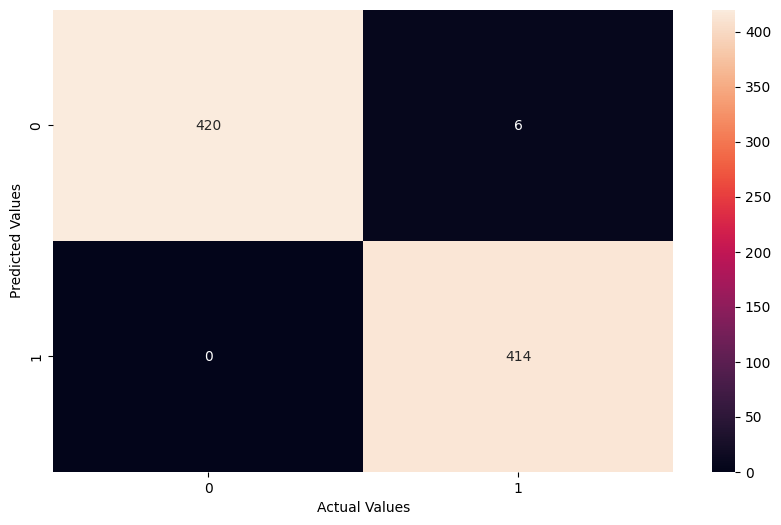

In [40]:
import seaborn as sns
plt.figure(figsize=(10,6))
sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

In [41]:
from sklearn.metrics import accuracy_score, f1_score,matthews_corrcoef,make_scorer, precision_score, recall_score, balanced_accuracy_score
score=accuracy_score(y_true,y_pred)
# scorers = {
#             'f1_score': make_scorer(f1_score, average='micro'),
#             # 'precision_score': make_scorer(precision_score, average='micro'),
#             # 'recall_score': make_scorer(recall_score, average='micro'),
#             'accuracy_score': make_scorer(accuracy_score)
# }
f1 = f1_score(y_true, y_pred,  average='micro')
pre = precision_score(y_true, y_pred,  average='micro')
recall = recall_score(y_true, y_pred,  average='micro')
acc = balanced_accuracy_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true,y_pred)
# print(f"accuracy {score} f1 {f1} mcc {mcc}")

print(f1, pre, recall, acc,mcc)

0.9928571428571429 0.9928571428571429 0.9928571428571429 0.9929577464788732 0.9858148842026544


In [42]:
# # save it as a h5 file
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
model.save('random_mobilenetV2.h5')

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
model=load_model('/content/random_mobilenetV2.h5')

In [57]:
img=image.load_img('/content/drive/MyDrive/dataset/random model/test/medical/1002.png',target_size=(224,224))
x=image.img_to_array(img)
x=x/255
x.shape

(224, 224, 3)

In [58]:
# # from keras.applications.xception import preprocess_input
# import numpy as np
# x=np.expand_dims(x,axis=0)
# img_data=preprocess_input(x)
# img_data.shape

In [59]:
img_data = x.reshape(1,224,224,3)

In [60]:
result = model.predict(img_data)
result

1/1 [==============================] - 0s 22ms/step


array([[5.4431193e-06]], dtype=float32)

In [ ]:
a=np.argmax(model.predict(img_data), axis=1)
a

In [ ]:
a==0 # 0 = covid, 1 = normal, 2= Pneumonia

In [ ]:
img_path = '/content/drive/MyDrive/breakHis_project/covid dataset/test/pneumonia/Viral Pneumonia-120.png'

category = img_path.split('/')[-1].split('-')[0].upper()
true = ''
if category == 'COVID':
    true = 'COVID'
elif category == 'VIRAL PNEUMONIA':
    true = 'Viral Pneumonia'
else:
    true = 'Normal'
print(f'True value is : {true}')

In [ ]:
image = load_img(img_path, target_size=(224, 224))
img = img_to_array(image)/255
img = img.reshape((1, 224, 224, 3))

result = model.predict(img)
result = np.argmax(result, axis=-1)
print(result)
print('Prediction is:')
if result == 0:
    print("COVID")
elif result == 1:
    print("Normal")
else:
    print("Viral Pneumonia ")
    
plt.imshow(image)